In [1]:
# ІМПОРТИ ТА НАЛАШТУВАННЯ
import pandas as pd
import numpy as np
import re
import nltk
from pathlib import Path

# Налаштування для візуалізації
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# ЗАВАНТАЖЕННЯ РЕСУРСІВ NLTK
# Завантажуємо необхідні пакети. 'punkt' для токенізації, 'stopwords' для стоп-слів.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ЗАВАНТАЖЕННЯ ДАНИХ
# Pathlib робить шлях сумісним з будь-якою ОС.
file_path = Path("C:/Users/Gitpc/OneDrive/Desktop/Testove Move revie/MovieReviewClassifier/IMDB Dataset.csv")

# Завантажуємо дані в pandas DataFrame
df = pd.read_csv(file_path)

# Перевіряємо, чи все завантажилось правильно
print("Розмір датасету:", df.shape)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gitpc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gitpc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Gitpc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Розмір датасету: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [2]:
# Створюємо набір англійських стоп-слів для швидкого доступу
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Видаляємо HTML-теги
    text = re.sub(r'<.*?>', '', text)
    # 2. Видаляємо все, крім літер (цифри, пунктуацію)
    # Виправляємо DeprecationWarning, вказуючи flags=
    text = re.sub(r'[^a-zA-Z\s]', '', text, flags=re.I|re.A)
    # 3. Приводимо до нижнього регістру
    text = text.lower()
    # 4. Розбиваємо на слова (токенізація)
    tokens = word_tokenize(text)
    # 5. Видаляємо стоп-слова та занадто короткі слова
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    # 6. З'єднуємо слова назад у рядок
    return " ".join(filtered_tokens)

# Застосовуємо нашу функцію до колонки 'review'.
# Використовуємо .copy(), щоб уникнути попередження SettingWithCopyWarning
df_processed = df.copy()
df_processed['cleaned_review'] = df_processed['review'].apply(preprocess_text)

# Перевіряємо результат
print("Оригінальний відгук:")
print(df_processed['review'][0])
print("\nОчищений відгук:")
print(df_processed['cleaned_review'][0])

# Дивимось на результат
df_processed.head()

Оригінальний відгук:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the s

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching episode youll...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ініціалізуємо векторизатор
# max_features=5000 - беремо 5000 найпопулярніших слів, щоб обмежити розмір матриці
vectorizer = TfidfVectorizer(max_features=5000)

# Створюємо матрицю ознак X та вектор цільової змінної y
X = vectorizer.fit_transform(df_processed['cleaned_review'])
y = df_processed['sentiment'].apply(lambda x: 1 if x == 'positive' else 0) # Перетворюємо 'positive'/'negative' в 1/0

# Перевіряємо розміри
print("Розмір матриці ознак (X):", X.shape)
print("Розмір вектора цілі (y):", y.shape)

Розмір матриці ознак (X): (50000, 5000)
Розмір вектора цілі (y): (50000,)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Розділяємо дані. stratify=y гарантує однакове співвідношення класів в обох наборах.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42, # Для відтворюваності результатів
    stratify=y
)

# Ініціалізуємо та навчаємо модель
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Робимо передбачення на тестових даних
y_pred = model.predict(X_test)

# Виводимо метрики
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

# Для більш детального звіту
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Accuracy: 0.8881
Precision: 0.8810131553112115
Recall: 0.8974
F1-Score: 0.8891310809471912

Classification Report:

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [6]:
# Беремо 5 випадкових відгуків
random_samples = df_processed.sample(5, random_state=50) # random_state для відтворюваності

# Готуємо відгуки для моделі
sample_texts = random_samples['cleaned_review']
sample_vectors = vectorizer.transform(sample_texts)

# Робимо передбачення
sample_predictions = model.predict(sample_vectors)
predicted_labels = ['Positive' if pred == 1 else 'Negative' for pred in sample_predictions]

# Виводимо результати
for i, (index, row) in enumerate(random_samples.iterrows()):
    print(f"--- ВІДГУК #{i+1} ---")
    print("Текст:", row['review'][:300] + "...") # Показуємо перші 300 символів
    print("Справжній :", row['sentiment'])
    print("Передбачений :", predicted_labels[i])
    print("-" * 20 + "\n")

--- ВІДГУК #1 ---
Текст: I didn't know what to expect from this. I always considered Bam Margera and the CKY crew a team of knuckle heads devoted to to doing stupid things for entertainment. I didn't know that they could act. But everyone who acted in this movie pulled off good performances. The hilarity of the 'aaaaagh!' s...
Справжній : positive
Передбачений : Positive
--------------------

--- ВІДГУК #2 ---
Текст: *** THIS CONTAINS MANY, MANY SPOILERS, NOT THAT IT MATTERS, SINCE EVERYTHING IS SO PATENTLY OBVIOUS ***<br /><br />Oh my God, where do I start? Well, here - this is the first time I have ever come home from a movie and said "I have to get on IMDb and write a review of this NOW. It is my civic duty."...
Справжній : negative
Передбачений : Negative
--------------------

--- ВІДГУК #3 ---
Текст: First thing I note is the music. It's nothing as amazing as Ruggero Deodato's Cannibal Holocaust's haunting theme or the masterpiece waltz from A Tale of Two Sisters, but I don't let 

C:\Users\Gitpc\AppData\Local\Temp\ipykernel_9920\2247874891.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=df_pos_words, palette='viridis')
C:\Users\Gitpc\AppData\Local\Temp\ipykernel_9920\2247874891.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=df_neg_words, palette='plasma')


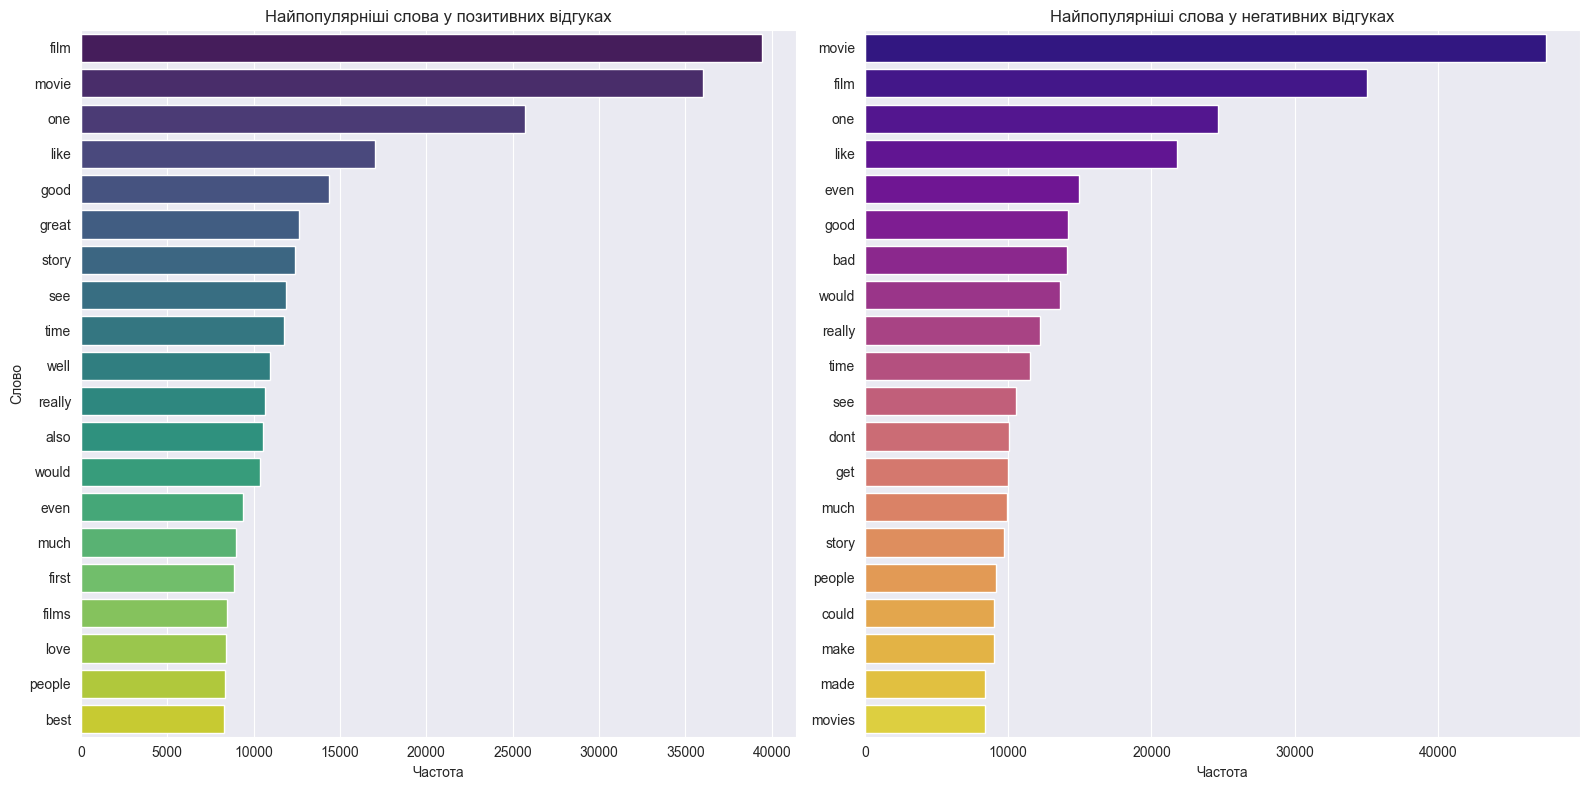

In [7]:
from collections import Counter

# Розділяємо відгуки на позитивні та негативні
positive_reviews = df_processed[df_processed['sentiment'] == 'positive']['cleaned_review']
negative_reviews = df_processed[df_processed['sentiment'] == 'negative']['cleaned_review']

# Об'єднуємо всі слова в один список для кожного настрою
positive_words = " ".join(positive_reviews).split()
negative_words = " ".join(negative_reviews).split()

# Рахуємо 20 найпопулярніших слів
positive_word_counts = Counter(positive_words).most_common(20)
negative_word_counts = Counter(negative_words).most_common(20)

# Створюємо DataFrame для зручної візуалізації
df_pos_words = pd.DataFrame(positive_word_counts, columns=['word', 'count'])
df_neg_words = pd.DataFrame(negative_word_counts, columns=['word', 'count'])

# Візуалізуємо
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=df_pos_words, palette='viridis')
plt.title('Найпопулярніші слова у позитивних відгуках')
plt.xlabel('Частота')
plt.ylabel('Слово')

plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=df_neg_words, palette='plasma')
plt.title('Найпопулярніші слова у негативних відгуках')
plt.xlabel('Частота')
plt.ylabel('') # Прибираємо підпис осі, щоб не дублювати

plt.tight_layout()
plt.show()